# Capítulo 5 - Scripts Principais


In [1]:
!mkdir results

## 1. Para Rodar no Colab

Basta clicar no link abaixo para abrir no Colab. Depois, execute a célula abaixo para fazer as configurações necessárias.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap03/MDPs%20e%20retornos.ipynb) 

Se você não estiver rodando no Google Colab, o import inicial vai fazer a célula dar um erro.

In [27]:
from google.colab import output

!pip install gym
!pip install gym[box2d]
!pip install optuna

!git clone https://github.com/pablo-sampaio/rl_facil

!mv /content/rl_facil/cap04/* /content/
!mv /content/rl_facil/cap05/* /content/

output.clear()

ModuleNotFoundError: No module named 'google'

## 2. Lidando com Ambientes Contínuos

Vamos usar os mesmos algoritmos de antes, baseados em Q-Table, para lidar com ambientes contínuos. Para isso, vamos usar um wrapper.

In [4]:
import gym
import numpy as np

from util_experiments import test_greedy_Q_policy
from util_plot import plot_returns

from expected_sarsa import run_expected_sarsa
#from qlearning import run_qlearning

from wrappers import DiscreteObservationWrapper

In [5]:
# 1. Cria o ambiente contínuo
ENV_NAME = "CartPole-v1"
r_max_plot = 200

env = gym.make(ENV_NAME)

d:\Pablo\anaconda3\envs\rlx\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [6]:
# vamos ver como é um estado deste ambiente?
print("Espaço de estados/observações: ", env.observation_space)
print("  - formato: ", env.observation_space.shape)
print("  - exemplo: ", env.reset())

Espaço de estados/observações:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
  - formato:  (4,)
  - exemplo:  [ 0.04362579  0.04925568 -0.01075318  0.01277133]


In [7]:
# 2. Encapsula o ambiente em nosso wrapper
# atenção para o 2o parâmetro: deve ter um valor para cada componente do estado
env = DiscreteObservationWrapper(env, [20,50,10,20]) 

In [8]:
# 3. Roda um algoritmo de treinamento

EPISODES = 1000
LR = 0.5
GAMMA = 0.95
EPSILON = 0.1

rewards, Qtable = run_expected_sarsa(env, EPISODES, LR, GAMMA, EPSILON, render=False)

print("Últimos resultados: media =", np.mean(rewards[-20:]), ", desvio padrao =", np.std(rewards[-20:]))


Episode 100 Average Reward (last 100): 32.690
Episode 200 Average Reward (last 100): 49.610
Episode 300 Average Reward (last 100): 37.910
Episode 400 Average Reward (last 100): 43.810
Episode 500 Average Reward (last 100): 61.340
Episode 600 Average Reward (last 100): 50.550
Episode 700 Average Reward (last 100): 49.800
Episode 800 Average Reward (last 100): 61.270
Episode 900 Average Reward (last 100): 50.970
Episode 1000 Average Reward (last 100): 59.590
Últimos resultados: media = 80.1 , desvio padrao = 78.9936073362902


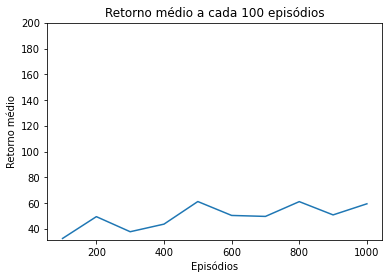

Nenhum arquivo salvo.


In [9]:
# 4. Gera um gráfico de episódios x retornos (não descontados)

filename = f"results/expected_sarsa-{ENV_NAME.lower()[0:8]}-ep{EPISODES}-lr{LR}.png"
plot_returns(rewards, r_max_plot, None)

In [10]:
# 5. Faz alguns testes, usando a tabela de forma greedy

test_greedy_Q_policy(env, Qtable, 10, render=False)
env.close()

Retorno médio (por episódio): 54.6, episódios: 10, total de passos: 546


## 3. Otimizando Parâmetros

Vamos usar a biblioteca *Optuna* para otimizar (hiper-)parâmetros dos algoritmos de treinamento.

In [22]:
import optuna

# vamos usar para limpar a saída
from IPython.display import clear_output


### Otimizando um ambiente discreto

É um caso um pouco mais simples, porque não precisamos aplicar o wrapper.

In [17]:
ENV = gym.make("Taxi-v3")


Primeiro, você precisa fazer uma função que receber um parâmetro "Trial" (objeto do optuna) e retorna uma medida de desempenho. 

Dentro da função, você usa o trial para pedir "sugestões" de valores para os hiper-parâmetros do seu algoritmo.

In [23]:
def train_exp_sarsa(trial : optuna.Trial):   
    # chama os métodos do "trial" (tentativa) para sugerir valores para os parâmetros
    lr = trial.suggest_uniform('learning_rate', 0.001, 1.0)
    #lr = trial.suggest_loguniform('learning_rate', 0.001, 1.0)
    eps = trial.suggest_uniform('epsilon', 0.01, 0.2)
    
    print(f"\nTRIAL #{trial.number}: lr={lr}, eps={eps}")

    # roda o algoritmo e recebe os retornos não-descontados
    (returns, _) = run_expected_sarsa(ENV, 2000, lr=lr, epsilon=eps)
    
    # limpa a saída da célula do notebook
    clear_output()

    # média dos retornos dos últimos 100 episódios
    return sum(returns[-100:])/100 


Depois, você cria um "study" do Optuna e manda otimizar sua função, indicando quantas tentativas (trials) ele vai fazer -- ou seja, quantas vezes a sua função vai ser executada, com o optuna oferecendo diferentes sugestões dos parâmetros.

In [24]:
study = optuna.create_study(direction='maximize', 
                        storage='sqlite:///resultado_esarsa.db', 
                        study_name='resultado_esarsa',
                        load_if_exists=True)

# maximiza o valor de retorno de train_exp_sarsa, rodando "n_trials" vezes
study.optimize(train_exp_sarsa, n_trials=15) 

print("MELHORES PARÂMETROS:")
print(study.best_params)

[I 2022-07-21 10:14:15,380] Trial 25 finished with value: 6.56 and parameters: {'learning_rate': 0.37918100089921614, 'epsilon': 0.02753129311804936}. Best is trial 17 with value: 7.99.


MELHORES PARÂMETROS:
{'epsilon': 0.01095238596675123, 'learning_rate': 0.6100081089269185}


### Otimizando um ambiente contínuo

Neste cao, nós aplicamos o wrapper, que tem novos parâmetros (quantidade de "bins" por valor do estado). 

O wrapper é considerado parte da solução e, por isso, o ideal é tentar otimizar esses parâmetros. Por isso, o wrapper será criado dentro da função a ser otimizada.

In [25]:
# cria apenas a versão contínua
ENV = gym.make("CartPole-v1")


d:\Pablo\anaconda3\envs\rlx\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [26]:
def train_exp_sarsa_continuous(trial : optuna.Trial):
    
    # chama os métodos do "trial" (tentativa) para sugerir valores para os parâmetros
    lr = trial.suggest_uniform('learning_rate', 0.001, 1.0)
    eps = trial.suggest_uniform('epsilon', 0.01, 0.2)
    bins1 = trial.suggest_int('bins1', 5, 100)
    bins2 = trial.suggest_int('bins2', 5, 100)
    
    print(f"\nTRIAL #{trial.number}: lr={lr}, eps={eps}, bins=[{bins1},{bins2}]")

    # cria o wrapper e roda o algoritmo, recebendo os retornos não-descontados
    env_wrapper = DiscreteObservationWrapper(ENV, [bins1,bins2])
    (returns, _) = run_expected_sarsa(env_wrapper, 2000, lr=lr, epsilon=eps)

    # limpa a saída da célula do notebook
    clear_output()

    # média dos retornos dos últimos 100 episódios
    return sum(returns[-100:])/100 


In [ ]:
study = optuna.create_study(direction='maximize', 
                        storage='sqlite:///resultado_esarsa_cont.db', 
                        study_name='resultado_esarsa_cont',
                        load_if_exists=True)

# maximiza o valor de retorno de train_exp_sarsa_continuous, rodando "n_trials" vezes
study.optimize(train_exp_sarsa_continuous, n_trials=20) 

print("MELHORES PARÂMETROS:")
print(study.best_params)

## 4. Fazer Experimentos Completos

Agora que você descobriu bons parâmetros, que tal rodar um treinamento mais longo com o seu algoritmo?

In [ ]:
# o código é por sua conta aqui!